In [1]:
import pandas as pd
from jupyter_server.utils import fetch
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
)
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.over_sampling import SMOTE
from datetime import datetime
from imblearn.pipeline import Pipeline as ImbPipeline
from catboost import CatBoostClassifier, Pool, cv
import seaborn as sns


In [2]:
RANDOM_STATE = 42
K_FOLDS = 5
RESULT_PATH = "../results/"
RESULT_FINE_NAME = "model_comparison_results."
RESULT_FINE_EXT = "csv"
DATASET_PATH = "../data/Telco-Customer-Churn.csv"
TEST_SIZE = 0.2
TARGET_COLUMN = "Churn"

results = {}

In [3]:
def load_and_preprocess(
        filepath: str,
        drop_aux=False,
        encode_binary=False,
        map_gender=False,
        one_hot_encoding=False,
        scale_numeric=False,
        to_numeric=False,
        encode_target=True,
) -> pd.DataFrame:
    churn_df = pd.read_csv(filepath)
    if drop_aux:
        # Drop customerID
        churn_df = churn_df.drop(columns=["customerID"])

    if to_numeric:
        # Convert TotalCharges to numeric and drop missing values
        churn_df["TotalCharges"] = pd.to_numeric(
            churn_df["TotalCharges"], errors="coerce"
        )
        churn_df = churn_df.dropna(subset=["TotalCharges"])

    if encode_binary:
        # Encode binary features
        binary_cols = ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]
        for col in binary_cols:
            churn_df[col] = churn_df[col].map({"Yes": 1, "No": 0})

    if encode_target:
        # Encode target variable
        churn_df["Churn"] = churn_df["Churn"].map({"Yes": 1, "No": 0})

    if map_gender:
        # Map gender
        churn_df["gender"] = churn_df["gender"].map({"Male": 1, "Female": 0})

    if one_hot_encoding:
        # One-hot encode remaining categorical variables
        categorical_cols = churn_df.select_dtypes(include=["object"]).columns.tolist()
        churn_df = pd.get_dummies(churn_df, columns=categorical_cols, drop_first=True)

    if scale_numeric:
        # Scale numeric features
        numeric_cols = ["tenure", "MonthlyCharges", "TotalCharges"]
        scaler = StandardScaler()
        churn_df[numeric_cols] = scaler.fit_transform(churn_df[numeric_cols])

    return churn_df

In [4]:
df = load_and_preprocess(
    filepath=DATASET_PATH,
    drop_aux=True,
    encode_binary=True,
    map_gender=True,
    one_hot_encoding=True,
    scale_numeric=True,
    to_numeric=True,
)

### Handling Class Imbalance with SMOTE

In our dataset, the target variable **Churn** is moderately imbalanced, with approximately **73% non-churn** and **27% churn** cases. This imbalance can lead to biased model performance, where classifiers favor the majority class (non-churn) and fail to correctly identify minority class instances (churned customers). Such a bias is especially problematic in churn prediction tasks, where identifying customers at risk of leaving is crucial for business actions.

To address this, we employed **SMOTE (Synthetic Minority Over-sampling Technique)** on the training data. SMOTE works by creating synthetic examples of the minority class based on the feature space similarities between existing minority samples. This method helps balance the dataset without simply duplicating existing instances.

We applied SMOTE **only to the training set** to avoid data leakage and then retrained all models using the oversampled data. The evaluation was still performed on the original test set to ensure fair comparison.

As a result, we observed that the recall and F1-scores of models improved, particularly for the minority class, without significantly harming overall performance. This indicates better sensitivity to churned customers, aligning with the project's predictive goal.


In [5]:
y = df[TARGET_COLUMN]
X = df.drop(columns=[TARGET_COLUMN])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

## Logistic Regression

In [69]:
lr_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(random_state=RANDOM_STATE, solver="liblinear"))
])

lr_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],
    'clf__penalty': ['l1', 'l2'],
    'clf__max_iter': [100, 200, 300, 500, 1000]
}

lr_grid_search = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=K_FOLDS,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
lr_grid_search.fit(X_train, y_train)
print("Best parameters:", lr_grid_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'clf__C': 0.01, 'clf__max_iter': 100, 'clf__penalty': 'l2'}


In [70]:
# Evaluation of the model
lr_y_pred = lr_grid_search.predict(X_test)

lr_y_proba = lr_grid_search.predict_proba(X_test)[:, 1]
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_y_proba)
lr_roc_auc = roc_auc_score(y_test, lr_y_proba)

results["Logistic Regression"] = {
    "values": {
        "accuracy": accuracy_score(y_test, lr_y_pred),
        "precision": precision_score(y_test, lr_y_pred),
        "recall": recall_score(y_test, lr_y_pred),
        "f1": f1_score(y_test, lr_y_pred),
        "roc_auc": roc_auc_score(y_test, lr_grid_search.predict_proba(X_test)[:, 1]),
    },
    "roc_curve": {
        "fpr": lr_fpr,
        "tpr": lr_tpr,
        "roc_auc": lr_roc_auc,
    },
    "confusion_matrix": confusion_matrix(y_test, lr_y_pred),
    "model": lr_grid_search.best_estimator_,
    "params": lr_grid_search.best_params_,
}
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81      1033
           1       0.51      0.76      0.61       374

    accuracy                           0.74      1407
   macro avg       0.70      0.75      0.71      1407
weighted avg       0.79      0.74      0.75      1407



## Support Vector Machine Classifier

In [ ]:
svm_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('scaler', StandardScaler()),
    ('clf', SVC(probability=True, random_state=RANDOM_STATE))
])
# svm_param_grid = {
#     'clf__C': [0.1, 1, 10, 100],
#     # 'clf__kernel': ['linear', 'rbf', 'poly'],
#     # 'clf__degree': [2, 3, 4],
#     'clf__kernel': ['linear', 'rbf'],
#     'clf__gamma': ['scale', 'auto']
# }
svm_param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}
svm_grid_search = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    cv=K_FOLDS,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
svm_grid_search.fit(X_train, y_train)
print("Best parameters:", svm_grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'clf__C': 0.1, 'clf__degree': 2, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}


In [72]:
svm_y_pred = svm_grid_search.predict(X_test)

svm_y_proba = svm_grid_search.predict_proba(X_test)[:, 1]
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_proba)
svm_roc_auc = roc_auc_score(y_test, svm_y_proba)

results["SVM"] = {
    "values": {
        "accuracy": accuracy_score(y_test, svm_y_pred),
        "precision": precision_score(y_test, svm_y_pred),
        "recall": recall_score(y_test, svm_y_pred),
        "f1": f1_score(y_test, svm_y_pred),
        "roc_auc": roc_auc_score(y_test, svm_grid_search.predict_proba(X_test)[:, 1]),
    },
    "roc_curve": {
        "fpr": svm_fpr,
        "tpr": svm_tpr,
        "roc_auc": svm_roc_auc,
    },
    "confusion_matrix": confusion_matrix(y_test, svm_y_pred),
    "model": svm_grid_search.best_estimator_,
    "params": svm_grid_search.best_params_,
}
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.75      0.81      1033
           1       0.52      0.75      0.62       374

    accuracy                           0.75      1407
   macro avg       0.71      0.75      0.71      1407
weighted avg       0.79      0.75      0.76      1407



## Random Forest Classifier

In [73]:
rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])
rf_param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=K_FOLDS,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

rf_grid_search.fit(X_train, y_train)
print("Best parameters:", lr_grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'clf__C': 0.01, 'clf__max_iter': 100, 'clf__penalty': 'l2'}


In [74]:
# Evaluation of Random Forest Classifier
rf_y_pred = rf_grid_search.predict(X_test)

rf_y_proba = rf_grid_search.predict_proba(X_test)[:, 1]
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_proba)
rf_roc_auc = roc_auc_score(y_test, rf_y_proba)

results["Random Forest"] = {
    "values": {
        "accuracy": accuracy_score(y_test, rf_y_pred),
        "precision": precision_score(y_test, rf_y_pred),
        "recall": recall_score(y_test, rf_y_pred),
        "f1": f1_score(y_test, rf_y_pred),
        "roc_auc": roc_auc_score(y_test, rf_grid_search.predict_proba(X_test)[:, 1]),
    },
    "roc_curve": {
        "fpr": rf_fpr,
        "tpr": rf_tpr,
        "roc_auc": rf_roc_auc,
    },
    "confusion_matrix": confusion_matrix(y_test, rf_y_pred),
    "model": rf_grid_search.best_estimator_,
    "params": rf_grid_search.best_params_,
}
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1033
           1       0.51      0.73      0.60       374

    accuracy                           0.74      1407
   macro avg       0.70      0.74      0.71      1407
weighted avg       0.78      0.74      0.75      1407



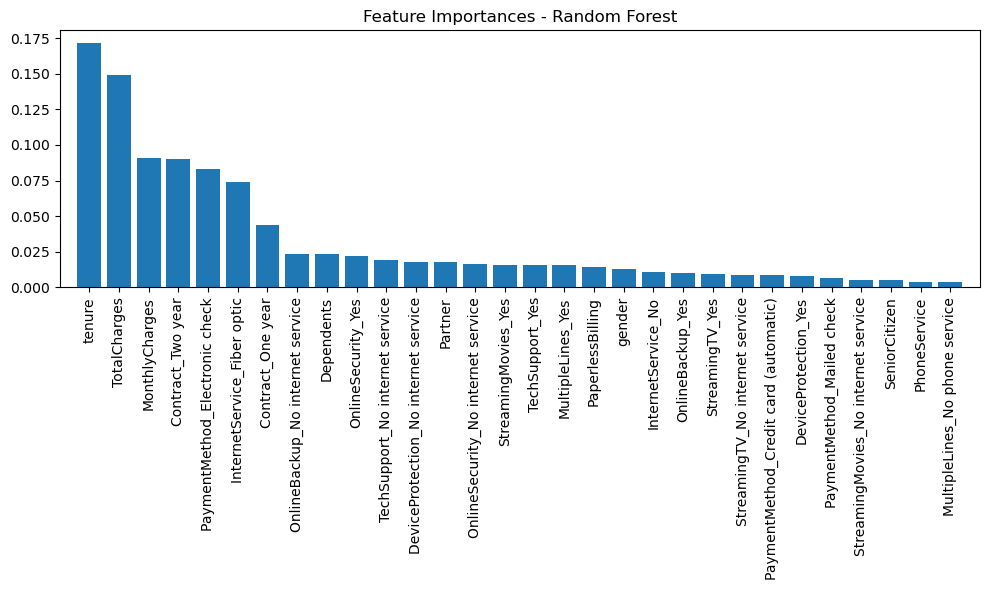

In [75]:
# Feature importance for Random Forest
importances = rf_grid_search.best_estimator_.named_steps['clf'].feature_importances_
feature_names = X.columns
indices = importances.argsort()[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(X.shape[1]), importances[indices], align='center')
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

## CatBoost Classifier

In [76]:
cb_df = load_and_preprocess(
    filepath=DATASET_PATH,
    drop_aux=True,
    encode_binary=False,
    map_gender=False,
    one_hot_encoding=False,
    scale_numeric=False,
    to_numeric=True,
    encode_target=True,
)

categorical_features = [
    "gender",
    "Partner",
    "Dependents",
    "PhoneService",
    "MultipleLines",
    "InternetService",
    "OnlineSecurity",
    "OnlineBackup",
    "DeviceProtection",
    "TechSupport",
    "StreamingTV",
    "StreamingMovies",
    "Contract",
    "PaperlessBilling",
    "PaymentMethod",
]

cb_X = cb_df.drop(columns=[TARGET_COLUMN])
cb_y = cb_df[TARGET_COLUMN]

cb_X_train, cb_X_test, cb_y_train, cb_y_test = train_test_split(cb_X, cb_y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)


In [77]:
train_pool = Pool(cb_X_train, cb_y_train, cat_features=categorical_features)
test_pool = Pool(cb_X_test, cb_y_test, cat_features=categorical_features)
cb_cv_param_grid = {
    "loss_function": "Logloss",
    "eval_metric": "F1",
    "random_seed": RANDOM_STATE,
    "verbose": False,
    "iterations": 1000,
    "early_stopping_rounds": 50,
}
cv_results = cv(
    params=cb_cv_param_grid,
    pool=train_pool,
    fold_count=K_FOLDS,
    partition_random_seed=RANDOM_STATE,
    verbose=False,
    plot=True,
)
# cv_results = cv(
#     params=cb_cv_param_grid, pool=train_pool, fold_count=K_FOLDS, verbose=False, plot=True
# )
best_iteration = cv_results['iterations'].max()
print(f"Best Iteration: {best_iteration}")


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.6069469835
bestIteration = 159

Training on fold [1/5]

bestTest = 0.5934489403
bestIteration = 40

Training on fold [2/5]

bestTest = 0.5758754864
bestIteration = 1

Training on fold [3/5]

bestTest = 0.6030534351
bestIteration = 93

Training on fold [4/5]

bestTest = 0.5817490494
bestIteration = 73

Best Iteration: 209


In [78]:
cb_param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [1, 3, 5],
    "early_stopping_rounds": [5, 10, 25, 50],
}
cb_classifier = CatBoostClassifier(
    iterations=best_iteration,
    loss_function="Logloss",
    eval_metric="F1",
    random_seed=RANDOM_STATE,
    verbose=False
)
cb_grid_search = GridSearchCV(
    cb_classifier,
    cb_param_grid,
    cv=K_FOLDS,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)
cb_grid_search.fit(cb_X_train, cb_y_train, cat_features=categorical_features)
print("Best parameters:", cb_grid_search.best_params_)



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'depth': 4, 'early_stopping_rounds': 5, 'l2_leaf_reg': 3, 'learning_rate': 0.1}


In [79]:
# evaluation of CatBoost Classifier
cb_y_pred = cb_grid_search.predict(cb_X_test)

cb_y_proba = cb_grid_search.predict_proba(cb_X_test)[:, 1]
cb_fpr, cb_tpr, _ = roc_curve(cb_y_test, cb_y_proba)
cb_roc_auc = roc_auc_score(cb_y_test, cb_y_proba)

results["CatBoost"] = {
    "values": {
        "accuracy": accuracy_score(cb_y_test, cb_y_pred),
        "precision": precision_score(cb_y_test, cb_y_pred),
        "recall": recall_score(cb_y_test, cb_y_pred),
        "f1": f1_score(cb_y_test, cb_y_pred),
        "roc_auc": roc_auc_score(cb_y_test, cb_grid_search.predict_proba(cb_X_test)[:, 1]),
    },
    "roc_curve": {
        "fpr": cb_fpr,
        "tpr": cb_tpr,
        "roc_auc": cb_roc_auc,
    },
    "confusion_matrix": confusion_matrix(cb_y_test, cb_y_pred),
    "model": cb_grid_search.best_estimator_,
    "params": cb_grid_search.best_params_,
}
print(classification_report(cb_y_test, cb_y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.52      0.58       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.79      0.79      0.79      1407



## Model Comparison

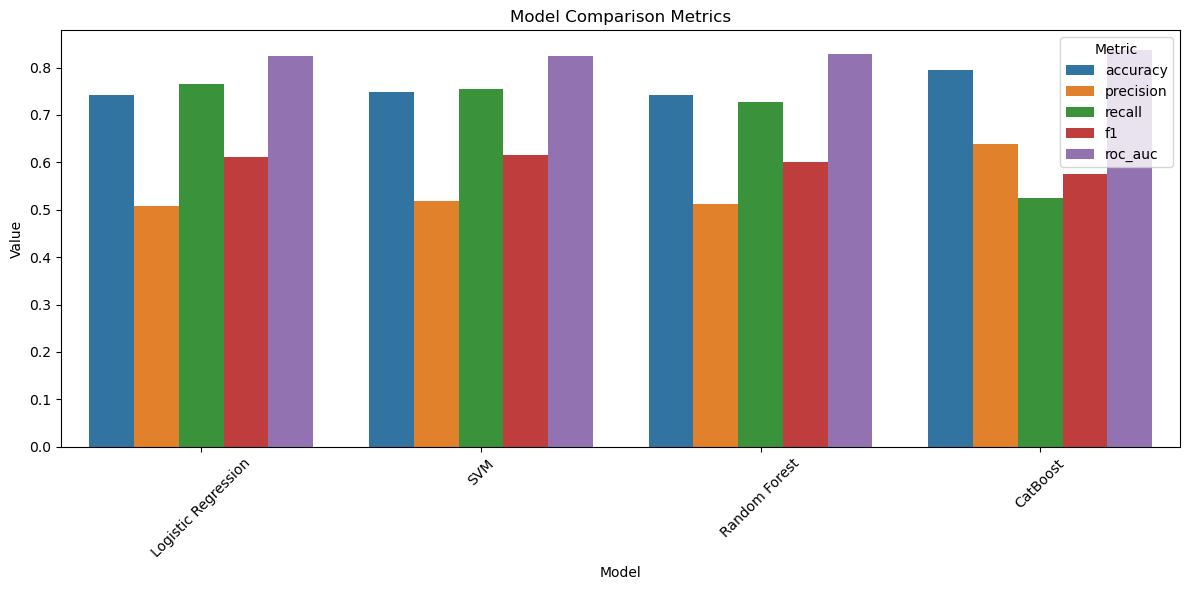

In [80]:
# comparision of model metrics
dynamic_df = pd.DataFrame.from_dict(
    {k: v["values"] for k, v in results.items()},
    orient='index'
).reset_index().rename(columns={'index': 'Model'})
dynamic_df = dynamic_df.melt(id_vars='Model', var_name='Metric', value_name='Value')
plt.figure(figsize=(12, 6))
sns.barplot(data=dynamic_df, x='Model', y='Value', hue='Metric')
plt.title('Model Comparison Metrics')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [85]:
results_df = pd.DataFrame.from_dict(
    {model: res["values"] for model, res in results.items()},
    orient='index'
)

results_df.to_csv(f"{RESULT_PATH}{RESULT_FINE_NAME}{datetime.now().strftime('%Y%m%d_%H%M%S')}.{RESULT_FINE_EXT}")
results_df


,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.741294,0.508897,0.764706,0.611111,0.823403
SVM,0.749112,0.519337,0.754011,0.615049,0.823439
Random Forest,0.742715,0.511278,0.727273,0.600442,0.828522
CatBoost,0.794598,0.638436,0.524064,0.575624,0.836746


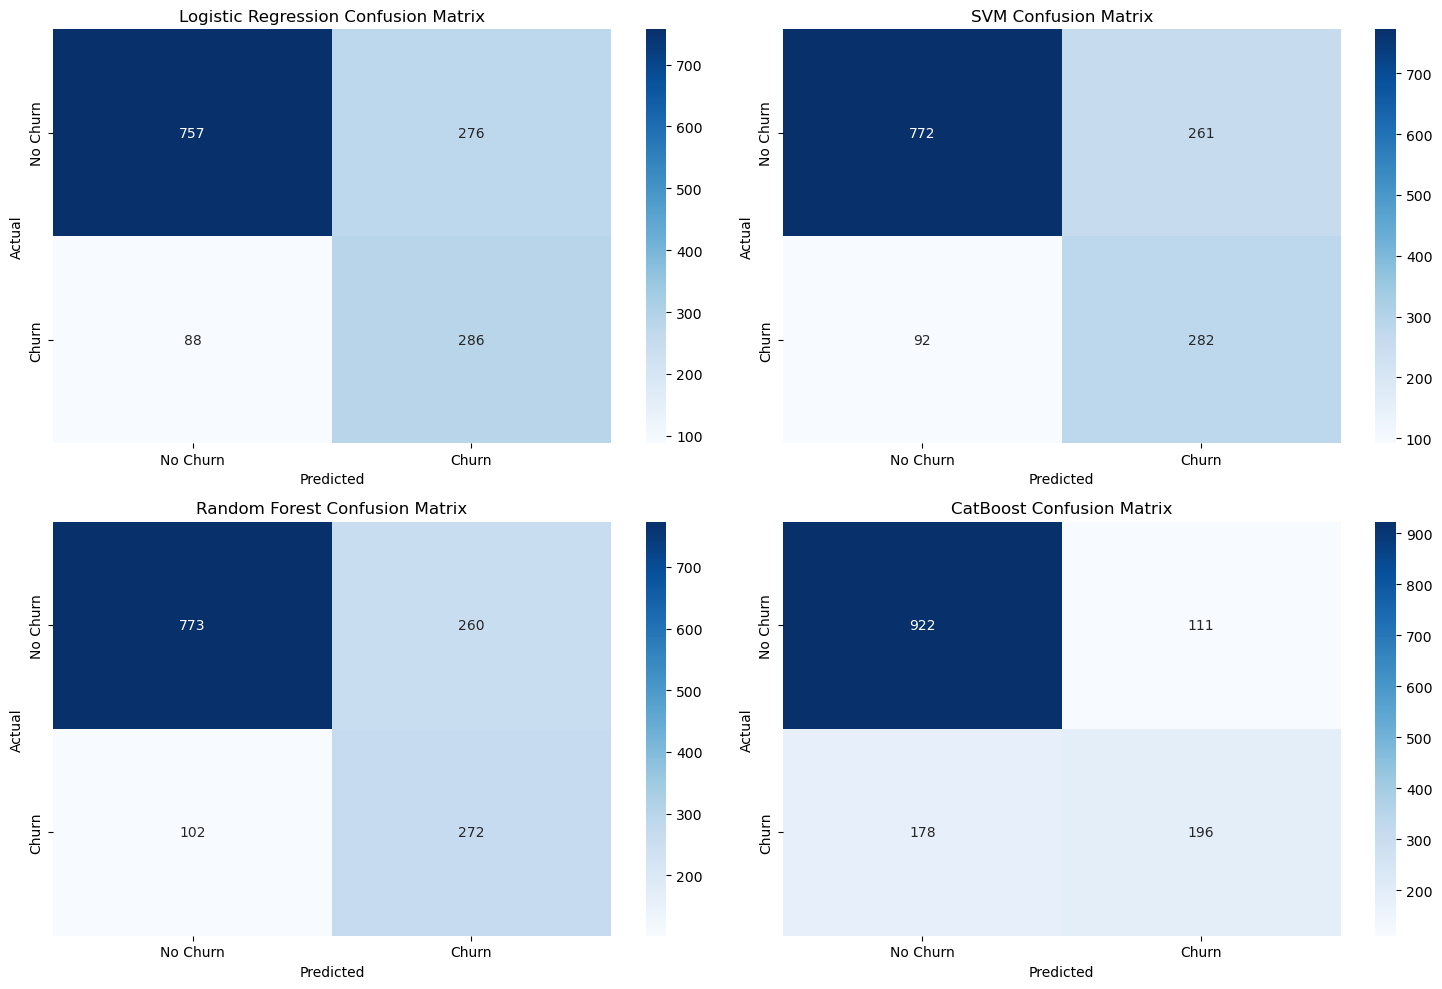

In [83]:
# confusion matrices
n_models = len(results)
cols = 2
rows = (n_models + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten() if n_models > 1 else [axes]
for i, (model_name, res) in enumerate(results.items()):
    cm = res["confusion_matrix"]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f"{model_name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
    axes[i].set_xticklabels(["No Churn", "Churn"])
    axes[i].set_yticklabels(["No Churn", "Churn"])
plt.tight_layout()
plt.show()

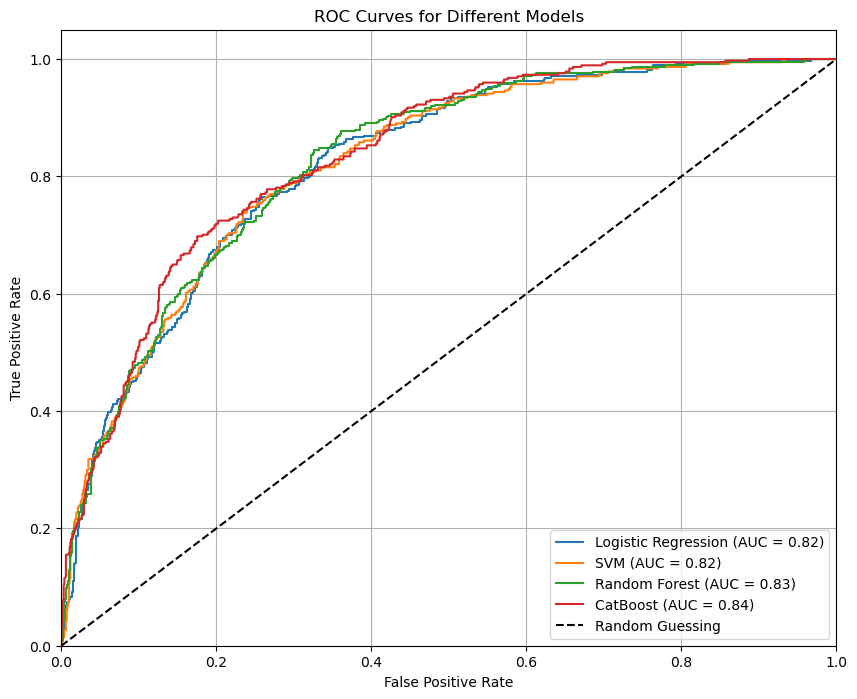

In [84]:
# plot ROC curves
plt.figure(figsize=(10, 8))
for model_name, res in results.items():
    fpr = res["roc_curve"]["fpr"]
    tpr = res["roc_curve"]["tpr"]
    auc_score = res["roc_curve"]["roc_auc"]
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curves for Different Models')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()